# Recomendador de parejas con Speed Dating

**Práctica 2:** Aplicaciones del Aprendizaje Automático  
**Asignatura:** Aprendizaje Automático | Master en Inteligencia Artificial y Big Data  
**Autor:** Jose Luis Cendan  
**Fecha:** 15/02/2026

---

Para esta práctica he buscado un caso de uso donde el aprendizaje automático realmente aporte algo frente a las reglas manuales, y he acabado eligiendo el dataset de Speed Dating de OpenML (ID 40536). Son 8.378 interacciones reales de citas rápidas con 121 variables: valoraciones mutuas de atractivo, sinceridad, inteligencia, humor, intereses compartidos... y si hubo match o no.

Lo que quiero hacer es un recomendador híbrido que combine filtrado colaborativo con filtrado por contenido, aplicando lo visto en la UD4. Pero antes, necesito entender cómo se agrupan los participantes, así que también hago un análisis no supervisado completo con técnicas de la UD3: clustering, reducción de dimensiones y detección de perfiles anómalos.

Las técnicas que aplico:

- K-Means y DBSCAN para clustering
- Método del Codo y Coeficiente de Silueta para seleccionar K
- PCA (con Scree Plot) y t-SNE para reducción de dimensionalidad
- Isolation Forest para detección de anomalías
- Recomendador híbrido (colaborativo + contenido)
- Hit Rate @5 para evaluación



## 1. Descripción del caso de uso

### Contexto
La mayoría de apps de citas recomiendan perfiles filtrando por edad y ubicación, poco más. El dataset de Speed Dating tiene algo que esas apps no ofrecen: valoraciones reales entre personas que se sentaron cara a cara durante 4 minutos y se puntuaron en atractivo, sinceridad, inteligencia, humor y ambición. Son datos de un experimento de la Columbia Business School (2002-2004), con 8.378 interacciones registradas.

### Objetivo
Quiero construir un sistema que recomiende parejas compatibles a partir de lo que realmente funcionó en esas citas. No me interesa solo saber "a quién le gustó quién", sino detectar qué combinaciones de perfiles tienden a acabar en match.

### ¿Por qué aprendizaje automático?
Porque las reglas simples no sirven aquí. Decir "si el atractivo es mayor de 7, hay match" no funciona: la compatibilidad depende de combinaciones de variables que no son evidentes a simple vista.   
Con K-Means puedo segmentar tipos de participantes según sus patrones, y con el recomendador híbrido puedo aprovechar tanto el comportamiento colectivo (filtrado colaborativo) como el perfil individual de cada persona (filtrado por contenido).

## 2. Configuracion del entorno


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.lines import Line2D
import warnings
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Todo importado, listo para empezar.")


Todo importado, listo para empezar.


## 3. Dataset

### Origen
El dataset viene de OpenML (ID 40536). Los datos los recogieron los profesores Ray Fisman y Sheena Iyengar en la Columbia Business School entre 2002 y 2004. El experimento consistía en sesiones de citas rápidas de 4 minutos donde los participantes se valoraban mutuamente después de cada encuentro.

### Variables principales

| Grupo | Variables | Descripción |
|-------|-----------|-------------|
| Valoraciones recibidas | `attractive_o`, `sincere_o`, `intelligence_o`, `funny_o`, `ambition_o` | Cómo valora la pareja al participante |
| Preferencias | `pref_o_attractive`, `pref_o_sincere`, etc. | Qué busca cada persona |
| Autovaloraciones | `attractive`, `sincere`, `intelligence`, `funny`, `ambition` | Cómo se valora a sí mismo |
| Intereses | `sports`, `dining`, `museums`, `art`, `gaming`, `reading` | Hobbies e intereses |
| Objetivo | `match` | 1 si ambos quieren repetir, 0 si no |


### Tamaño
8.378 registros y 121 columnas (el enunciado pide un mínimo de 300 registros).

Hay que tener en cuenta que la versión de OpenML no incluye los identificadores de usuario originales (`iid`/`pid`), así que cada fila se trata como una interacción independiente. Esto limita el filtrado colaborativo porque la matriz de utilidad queda reducida, pero no afecta al clustering ni al resto del análisis no supervisado, que trabajan directamente con las features de cada interacción.

### Carga del dataset
El archivo CSV se incluye junto con el notebook para garantizar la reproducibilidad. Originalmente se descargó de OpenML, pero se distribuye en local para evitar problemas de conexión o cambios en la plataforma.

In [127]:
# Dataset: Speed Dating (OpenML ID 40536)
# Origen: https://www.openml.org/d/40536
# Se incluye el CSV directamente para garantizar reproducibilidad
df = pd.read_csv('speed_dating.csv')
print(f"[OK] Dataset cargado: {df.shape[0]} registros, {df.shape[1]} variables")
df.to_csv('data/speed_dating.csv', index=False)
print("Guardado en data/speed_dating.csv")

[OK] Dataset cargado: 8378 registros, 121 variables
Guardado en data/speed_dating.csv


### Exploracion rapida


In [128]:
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())
print(f"\nDistribucion de Match:")
print(df['match'].value_counts())
match_rate = df['match'].value_counts(normalize=True).get(1, 0)
print(f"\nTasa de match: {match_rate:.1%}")
df.head()


Dimensiones: 8378 filas x 121 columnas

Tipos de datos:
str        59
float64    57
int64       5
Name: count, dtype: int64

Distribucion de Match:
match
0    6998
1    1380
Name: count, dtype: int64

Tasa de match: 16.5%


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1,female,21.0,27.0,6,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,0
1,0,1,female,21.0,22.0,1,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,0
2,1,1,female,21.0,22.0,1,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,[0-4],[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1
3,0,1,female,21.0,23.0,2,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1
4,0,1,female,21.0,24.0,3,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1


La tasa de match esta en torno al 16%, lo cual tiene sentido: en citas rapidas no sueles conectar con todo el mundo. Esto tambien implica un desbalance importante de clases (mucho mas "no match" que "match"), algo a tener en cuenta.


### Procesamiento del dataset

Pasos de limpieza:
1. Identificar columnas clave (si existen `iid`/`pid` se usan, si no el primer y segundo campo)
2. Convertir todo a numerico (OpenML carga muchas columnas como `category`)
3. Quedarse solo con features que tengan al menos 50% de datos y varianza positiva
4. Rellenar los nulos que queden con la mediana


In [129]:
# Busco las columnas clave del dataset (pueden tener nombres distintos según la fuente)
cols = df.columns.tolist()
user_col = 'iid' if 'iid' in cols else ('id' if 'id' in cols else cols[0])
partner_col = 'pid' if 'pid' in cols else ('partner' if 'partner' in cols else cols[1])
target_col = 'match' if 'match' in cols else cols[-1]
gender_col = 'gender' if 'gender' in cols else ('sex' if 'sex' in cols else None)

print(f"Columnas clave -> Usuario: {user_col}, Pareja: {partner_col}, Objetivo: {target_col}, Genero: {gender_col}")

df_clean = df.copy()

# Paso a numérico las columnas de IDs y target (OpenML las carga como categorías)
for col in [user_col, partner_col, target_col]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Elimino filas donde falten los campos imprescindibles
df_clean = df_clean.dropna(subset=[user_col, partner_col, target_col])

# Descarto IDs, género y raza de las features numéricas para que no metan sesgo
exclude_cols = [user_col, partner_col, target_col, 'race', 'field', 'from', 'zipcode', 'date']
if gender_col: exclude_cols.append(gender_col)

# Me quedo solo con features que tengan al menos 50% de datos válidos y varianza > 0
# Las que no aportan información (todo ceros o todo nulos) no sirven para clustering
feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
numeric_feats = []
for c in feature_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')
    if df_clean[c].notnull().sum() > len(df_clean)*0.5 and df_clean[c].std() > 0:
        numeric_feats.append(c)
        df_clean[c].fillna(df_clean[c].median(), inplace=True)

print(f"\nFeatures numéricas seleccionadas: {len(numeric_feats)}")
print(f"Primeras 10: {numeric_feats[:10]}")
print(f"Registros tras limpieza: {len(df_clean)}")

# Guardo el dataset limpio por si quiero trabajar con él después sin repetir todo esto
df_clean.to_csv('data/speed_dating_clean.csv', index=False)

Columnas clave -> Usuario: has_null, Pareja: wave, Objetivo: match, Genero: gender

Features numéricas seleccionadas: 58
Primeras 10: ['age', 'age_o', 'd_age', 'samerace', 'importance_same_race', 'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny']
Registros tras limpieza: 8378


## 4. Metodología

### 4.1 Sistema recomendador híbrido

Uso un recomendador híbrido porque ninguno de los dos enfoques por separado me convence del todo:

- El **filtrado colaborativo** busca patrones entre usuarios:
  > *Si a ti y a otra persona os gustan las mismas parejas, es probable que también os gustéis entre vosotros.*
  
  Para esto construyo una matriz de utilidad (usuario x pareja) y calculo la similitud coseno entre filas.

- El **filtrado por contenido** va por otro lado, compara directamente los perfiles:
  > *Si buscas a alguien inteligente y divertido, te recomienda personas con esas características, independientemente de lo que hayan hecho otros usuarios.*

- El **híbrido** combina ambos con un peso de 60% colaborativo y 40% contenido:
  > *Le doy más peso al colaborativo porque lo que la gente realmente hace (a quién elige) suele predecir mejor que lo que dice que busca en sus autovaloraciones.*

#### Filtrado colaborativo

In [130]:
# Matriz de utilidad: cada fila es un usuario, cada columna una pareja, 
# y el valor es si hubo match o no. Es la base del filtrado colaborativo.
print("Construyendo matriz de utilidad...")
utility_df = pd.DataFrame()
user_sim_df = pd.DataFrame()

try:
    utility_df = df_clean.groupby([user_col, partner_col])[target_col].mean().unstack(fill_value=0)
    print(f"Matriz Usuario-Item: {utility_df.shape}")
    
    # Similitud coseno entre usuarios: mide cuánto se parecen dos personas 
    # en función de a quién eligieron (no de sus características)
    print("Calculando similitud coseno...")
    user_sim = cosine_similarity(utility_df)
    user_sim_df = pd.DataFrame(user_sim, index=utility_df.index, columns=utility_df.index)
    print(f"Matriz de similitud: {user_sim_df.shape}")
except Exception as e:
    print(f"Error en filtrado colaborativo: {e}")

Construyendo matriz de utilidad...
Matriz Usuario-Item: (2, 21)
Calculando similitud coseno...
Matriz de similitud: (2, 2)


#### Filtrado basado en contenido


In [131]:
# Aquí va el filtrado por contenido: en vez de mirar a quién eligió cada persona,
# comparo directamente sus perfiles (valoraciones, intereses, preferencias).
# Escalo todo entre 0 y 1 con MinMaxScaler para que ninguna variable pese más que otra.
print("Construyendo perfiles de contenido...")
content_sim_df = pd.DataFrame()
if numeric_feats:
    try:
        user_profiles = df_clean[numeric_feats].dropna()
        scaler = MinMaxScaler()
        user_profiles_scaled = pd.DataFrame(
            scaler.fit_transform(user_profiles), 
            index=user_profiles.index, 
            columns=user_profiles.columns
        )
        # Similitud coseno entre perfiles: dos personas con gustos parecidos
        # tendrán un valor cercano a 1
        content_sim = cosine_similarity(user_profiles_scaled)
        content_sim_df = pd.DataFrame(content_sim, index=user_profiles.index, columns=user_profiles.index)
        print(f"Matriz de contenido: {content_sim_df.shape}")
    except Exception as e:
        print(f"Error en contenido: {e}")

Construyendo perfiles de contenido...
Matriz de contenido: (4859, 4859)


#### Función de recomendación híbrida
La función `get_recs()` junta los dos enfoques. Por la parte colaborativa, busca los 10 usuarios más parecidos al usuario objetivo y mira a quién les gustó a ellos. Por la parte de contenido, busca los perfiles más similares al suyo. Después suma ambas puntuaciones con los pesos que mencioné antes (60/40) y devuelve las mejores recomendaciones.

In [132]:
def get_recs(user_id, k=5):
    """Genera las top-k recomendaciones combinando colaborativo (60%) y contenido (40%)."""
    recs = {}
    
    # Parte colaborativa: busco los 10 usuarios más parecidos en comportamiento
    # y miro a quién les hizo match. Si alguien parecido a ti eligió a esa persona,
    # probablemente a ti también te encaje.
    if not user_sim_df.empty and user_id in user_sim_df.index:
        sim_users = user_sim_df[user_id].sort_values(ascending=False)[1:11]
        for other, sim in sim_users.items():
            if sim <= 0: continue
            try:
                liked = utility_df.loc[other]
                liked = liked[liked > 0.5]
                for item in liked.index:
                    recs[item] = recs.get(item, 0) + (sim * 0.6)
            except: pass
    
    # Parte de contenido: busco los 10 perfiles más parecidos al tuyo
    # (mismos intereses, valoraciones similares, etc.)
    if not content_sim_df.empty and user_id in content_sim_df.index:
        sim_users_cont = content_sim_df[user_id].sort_values(ascending=False)[1:11]
        for other, sim in sim_users_cont.items():
             recs[other] = recs.get(other, 0) + (sim * 0.4) 
    
    # Devuelvo las k mejores recomendaciones ordenadas por puntuación
    return sorted(recs.items(), key=lambda x: x[1], reverse=True)[:k]

# Pruebo con los 5 primeros usuarios para ver si el recomendador funciona
sample_users = df_clean[user_col].unique()[:5]
for u in sample_users:
    print(f"\nRecomendaciones para el usuario {u}:")
    recs = get_recs(u)
    if recs:
        for r, s in recs:
            print(f"  -> Debería conocer a: {r} (Score: {s:.3f})")
    else:
        print("  -> Sin info suficiente (Cold Start)")


Recomendaciones para el usuario 0:
  -> Debería conocer a: 5 (Score: 0.394)
  -> Debería conocer a: 6 (Score: 0.393)
  -> Debería conocer a: 3 (Score: 0.393)
  -> Debería conocer a: 4 (Score: 0.393)
  -> Debería conocer a: 8 (Score: 0.392)

Recomendaciones para el usuario 1:
  -> Debería conocer a: 3 (Score: 0.395)
  -> Debería conocer a: 0 (Score: 0.391)
  -> Debería conocer a: 5 (Score: 0.386)
  -> Debería conocer a: 8 (Score: 0.385)
  -> Debería conocer a: 4 (Score: 0.385)


### 4.2 Clustering con K-Means

Para segmentar a los participantes uso K-Means. Es el algoritmo más directo para este tipo de análisis y me permite agrupar las interacciones según patrones en sus 58 features numéricas (valoraciones, preferencias, intereses).

Empiezo con estos parámetros:
- `n_clusters=4` como punto de partida, aunque después lo verifico con el método del codo y el coeficiente de silueta
- `n_init=10` para que repita la inicialización varias veces y no se quede atrapado en un óptimo local
- `random_state=42` para que los resultados sean reproducibles

Antes de meter los datos en K-Means, los estandarizo con `StandardScaler`. Si no lo hago, variables con rangos grandes (como la edad) dominarían sobre otras con rangos pequeños (como las puntuaciones del 1 al 10). Después proyecto todo a 2D con PCA para poder visualizar los clusters en un gráfico.

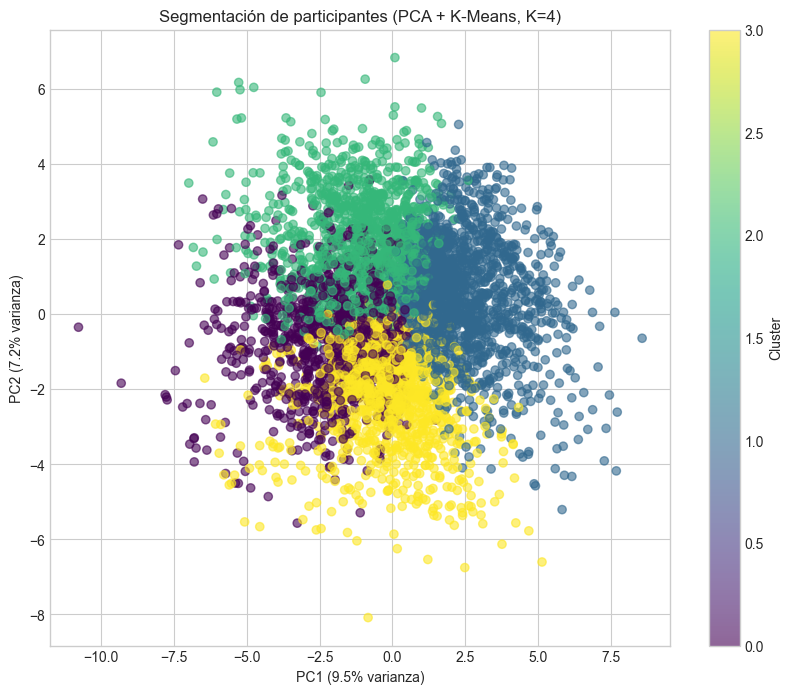

Distribución: {0: 1021, 1: 1541, 2: 1205, 3: 1092}


In [133]:
if numeric_feats:
    # Preparo los datos para clustering: cojo todas las interacciones con sus 58 features
    user_profiles_cluster = df_clean[numeric_feats].copy()
    user_profiles_cluster = user_profiles_cluster.dropna()
    
    # Estandarizo para que todas las variables estén en la misma escala
    scaler_cluster = StandardScaler()
    X_cluster = scaler_cluster.fit_transform(user_profiles_cluster)
    
    # Reduzco a 2 dimensiones con PCA para poder visualizar los clusters
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cluster)
    
    # Aplico K-Means con K=4 (después compruebo si es el K óptimo)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_cluster)
    
    # Gráfico de los clusters proyectados en las dos primeras componentes principales
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Segmentación de participantes (PCA + K-Means, K=4)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
    plt.savefig('results/user_clusters_pca.png')
    plt.show()
    
    # Cuántas interacciones hay en cada cluster
    print(f"Distribución: {pd.Series(clusters).value_counts().sort_index().to_dict()}")

**Que se ve en el grafico:** Los 4 clusters se reparten por el espacio PCA en 2D, aunque se solapan bastante entre sí.   
Esto no me sorprende por dos motivos: las dos primeras componentes principales solo recogen un 16.6% de la varianza total (la información está muy repartida entre las 58 dimensiones originales), y además el comportamiento humano rara vez se divide en categorías limpias y separadas. Aun así se puede ver cierta estructura: el cluster 3 (amarillo) tiende a concentrarse en la zona inferior derecha, y el 2 (verde) ocupa más la parte superior del gráfico.

#### Selección de K: método del codo

No quiero elegir el número de clusters a ojo, así que pruebo con K de 2 a 10 y calculo la inercia para cada uno (es la suma de distancias al cuadrado de cada punto a su centroide más cercano). La idea es buscar el punto donde la curva deja de bajar de forma pronunciada, el "codo", que indica que añadir más clusters ya no aporta mucho.

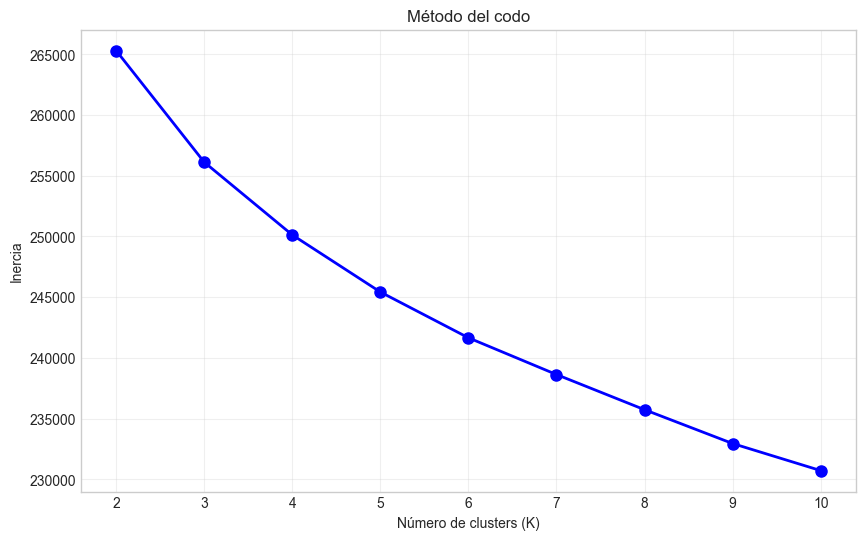

In [134]:
# Pruebo K de 2 a 10 y guardo la inercia de cada uno
inertias = []
K_range = range(2, 11)
for k in K_range:
    km_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_temp.fit(X_cluster)
    inertias.append(km_temp.inertia_)

# Dibujo la curva para buscar el codo visualmente
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(alpha=0.3)
plt.savefig('results/elbow_method.png')
plt.show()

**Interpretacion:** La curva baja de forma bastante gradual, sin un codo que salte a la vista.  
Es algo habitual con datos de tantas dimensiones: no hay una separación natural clara entre grupos.  
Aun así entre K=2 y K=4 la bajada es más fuerte, y a partir de K=5 la curva se aplana bastante.  
 Junto con el análisis de silueta que viene a continuación, me quedo con K=4 como un compromiso razonable entre tener suficientes grupos para que sean informativos y no tantos como para que pierdan sentido.

#### Calidad del clustering: coeficiente de silueta

Para saber si los clusters tienen sentido, uso el **coeficiente de silueta**.  
> Va de -1 a 1: un valor alto significa que cada punto está cerca de los demás de su cluster y lejos de los otros clusters.  

> Un valor cercano a 0 indica que los clusters se solapan mucho.

  K=2: Silueta = 0.056
  K=3: Silueta = 0.048
  K=4: Silueta = 0.045
  K=5: Silueta = 0.040
  K=6: Silueta = 0.038
  K=7: Silueta = 0.035
  K=8: Silueta = 0.031
  K=9: Silueta = 0.031
  K=10: Silueta = 0.034

Mejor K según silueta: 2 (score=0.056)


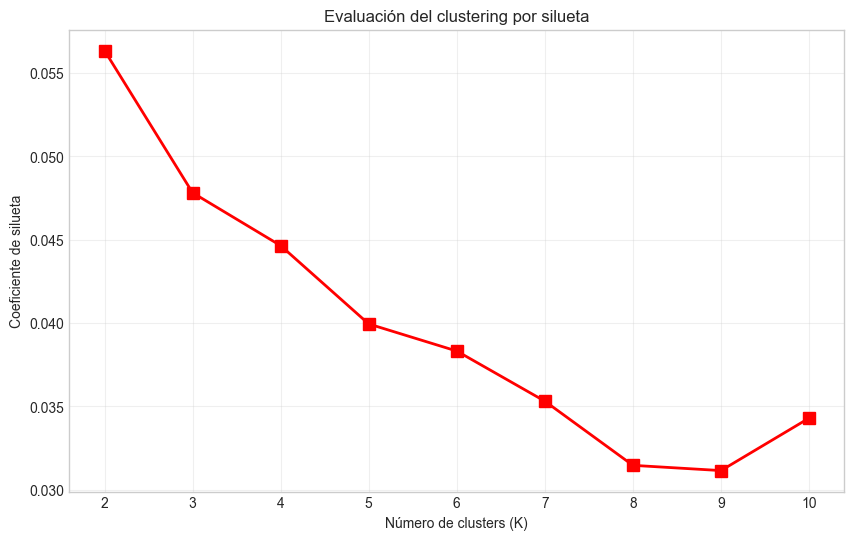

Silueta para K=4 (el que he usado): 0.045


In [135]:
# Calculo la silueta para cada K de 2 a 10 y me quedo con el mejor
sil_scores = []
for k in K_range:
    km_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = km_temp.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels_temp)
    sil_scores.append(score)
    print(f"  K={k}: Silueta = {score:.3f}")

best_k = list(K_range)[np.argmax(sil_scores)]
print(f"\nMejor K según silueta: {best_k} (score={max(sil_scores):.3f})")

# Gráfico de silueta vs K para ver cuál da mejor separación
plt.figure(figsize=(10, 6))
plt.plot(K_range, sil_scores, 'rs-', linewidth=2, markersize=8)
plt.xlabel('Número de clusters (K)')
plt.ylabel('Coeficiente de silueta')
plt.title('Evaluación del clustering por silueta')
plt.grid(alpha=0.3)
plt.savefig('results/silhouette_scores.png')
plt.show()

# Compruebo qué silueta tiene el K=4 que elegí inicialmente
sil_avg = silhouette_score(X_cluster, clusters)
print(f"Silueta para K=4 (el que he usado): {sil_avg:.3f}")

**Interpretacion:**   
Los valores de silueta son bajos en todos los casos: van de 0.03 a 0.056. El mejor según esta métrica es K=2 (0.056), pero la diferencia con K=4 (0.045) es mínima. Que la silueta sea baja con 58 dimensiones y datos de comportamiento humano no es raro: las personas no se dividen en grupos claramente separados, sino que forman más bien un espectro continuo. Esto no significa que el clustering no sirva, sino que las fronteras entre grupos son difusas, algo esperable en este tipo de datos.


#### DBSCAN: clustering por densidad

DBSCAN funciona de forma diferente a K-Means: no hace falta decirle cuántos clusters quiero, los encuentra solo buscando zonas donde hay muchos puntos concentrados. Lo que queda aislado lo etiqueta como ruido (label = -1), así que de paso sirve para detectar outliers.

He usado estos parámetros:
- `eps=5.0`: es el radio de vecindad. Lo puse relativamente alto porque con datos estandarizados de 58 dimensiones, si uso radios pequeños acaba marcando casi todo como ruido (es un efecto conocido de la "maldición de la dimensionalidad").
- `min_samples=5`: el mínimo de vecinos que necesita un punto dentro de su radio para que se considere zona densa.

Clusters encontrados: 265
Puntos de ruido (outliers): 1937 (39.9%)


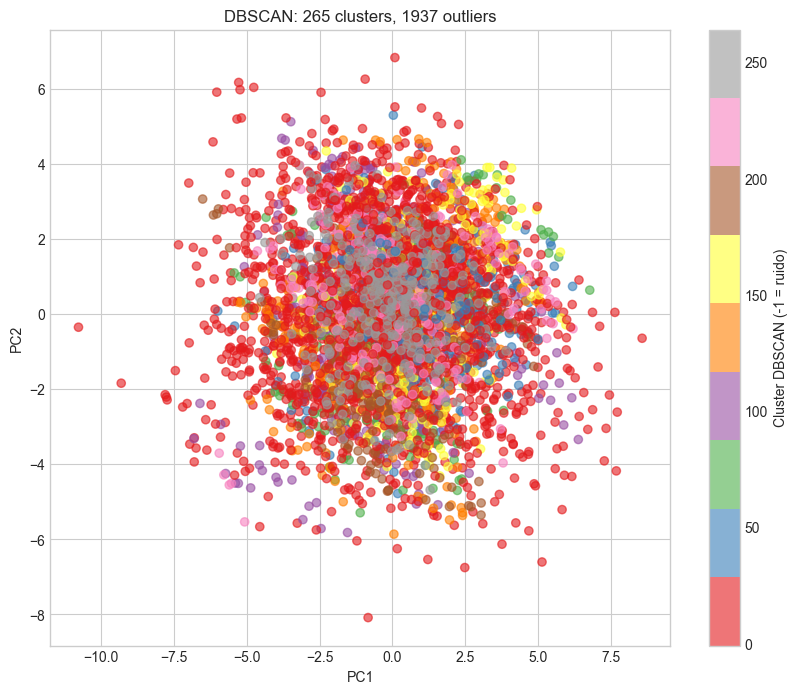

In [136]:
# Aplico DBSCAN sobre los mismos datos estandarizados
dbscan = DBSCAN(eps=5.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_cluster)

# Cuento cuántos clusters ha encontrado y cuántos puntos ha marcado como ruido
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Clusters encontrados: {n_clusters_db}")
print(f"Puntos de ruido (outliers): {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Visualizo los clusters de DBSCAN sobre la misma proyección PCA
plt.figure(figsize=(10, 8))
scatter_db = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='Set1', alpha=0.6)
plt.colorbar(scatter_db, label='Cluster DBSCAN (-1 = ruido)')
plt.title(f'DBSCAN: {n_clusters_db} clusters, {n_noise} outliers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('results/dbscan_clusters.png')
plt.show()

**Interpretacion:**  
DBSCAN encuentra 265 microclusters y marca el 39.9% de los puntos como ruido. Que haya tantos clusters pequeños me dice que no existen regiones de alta densidad bien definidas: los datos están muy repartidos por el espacio. El porcentaje alto de ruido va en la misma línea que la silueta baja de K-Means: los participantes no forman grupos compactos ni separados entre sí. La diferencia con K-Means es que este obliga a cada punto a pertenecer a un cluster, aunque esté en una zona intermedia. DBSCAN, al menos, es honesto y dice "esto no pertenece a ningún grupo claro".




#### Comparativa K-Means vs DBSCAN

| Aspecto | K-Means (K=4) | DBSCAN (eps=5.0) |
|---------|---------------|------------------|
| Clusters | 4 (fijados) | 265 (descubiertos) |
| Ruido | No detecta | 39.9% marcado como ruido |
| Silueta | 0.045 | No aplica (demasiados clusters) |
| Asunciones | Clusters esféricos, tamaño similar | Clusters de forma arbitraria |
| Conclusión | Agrupación forzada pero útil para segmentar | Confirma que no hay grupos densos claros |

Los dos algoritmos llegan a la misma conclusión por caminos diferentes: los participantes no forman grupos compactos. K-Means los segmenta igualmente porque obliga a asignar cada punto, mientras que DBSCAN es más honesto y marca como ruido lo que no encaja en ningún grupo.

### 4.3 Reducción de dimensionalidad

#### PCA y Scree Plot

Con el Scree Plot puedo ver cuánta información captura cada componente principal. Me interesa saber si las 2 componentes que uso para los gráficos están perdiendo demasiada información o si son suficientes para hacerse una idea de la estructura de los datos.

Aplico PCA completo (tantas componentes como features hay) para ver el espectro entero de varianza explicada.

Para capturar el 95% de varianza necesito 46 componentes (de 58)
PC1: 9.5%
PC2: 7.2%
PC1+PC2: 16.6% (las 2D que uso en los gráficos)


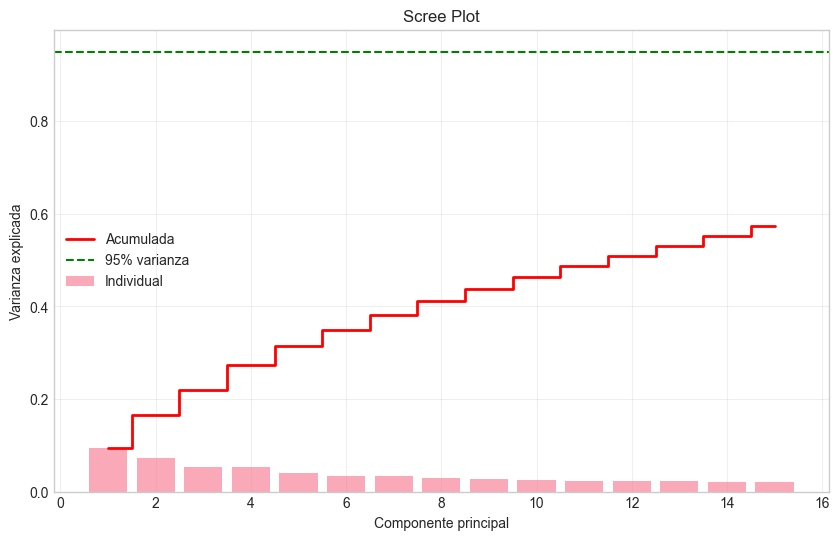

In [137]:
# PCA completo para ver cuántas componentes hacen falta realmente
pca_full = PCA()
pca_full.fit(X_cluster)

# ¿Cuántas componentes necesito para capturar el 95% de la información?
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
n_for_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"Para capturar el 95% de varianza necesito {n_for_95} componentes (de {X_cluster.shape[1]})")
print(f"PC1: {pca_full.explained_variance_ratio_[0]:.1%}")
print(f"PC2: {pca_full.explained_variance_ratio_[1]:.1%}")
print(f"PC1+PC2: {cumulative_var[1]:.1%} (las 2D que uso en los gráficos)")

# Scree Plot: barras para la varianza individual y línea roja para la acumulada
plt.figure(figsize=(10, 6))
n_show = min(15, len(pca_full.explained_variance_ratio_))
plt.bar(range(1, n_show + 1), pca_full.explained_variance_ratio_[:n_show], alpha=0.6, label='Individual')
plt.step(range(1, n_show + 1), cumulative_var[:n_show], where='mid', color='red', linewidth=2, label='Acumulada')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% varianza')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.title('Scree Plot')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('results/scree_plot.png')
plt.show()

**Interpretacion:**  
PC1 captura un 9.5% de la varianza y PC2 un 7.2%, lo que suma solo un 16.6% entre las dos. Para llegar al 95% necesito 46 de las 58 componentes. Esto me confirma que la información está muy repartida entre las variables, sin una o dos direcciones que dominen sobre el resto. También explica por qué los gráficos 2D que he pintado antes se ven tan solapados: estoy perdiendo más del 80% de la información al proyectar. En el espacio original de 58 dimensiones los clusters podrían estar algo más separados de lo que parece en 2D.


#### t-SNE: visualización no lineal

PCA busca las direcciones de máxima varianza, pero asume que las relaciones entre variables son lineales. t-SNE hace algo diferente: se fija en la estructura local de los datos. Si dos puntos están cerca en el espacio original de 58 dimensiones, intenta que sigan estando cerca en 2D.

He usado estos parámetros:
- `perplexity=30`: controla cuántos vecinos se consideran al calcular la estructura local. Valores entre 5 y 50 suelen dar resultados razonables.
- `random_state=42`: para que el resultado sea reproducible.

Una cosa a tener en cuenta: t-SNE solo sirve para visualizar. No se puede usar para reducir dimensiones de verdad porque no preserva las distancias globales, solo las locales.

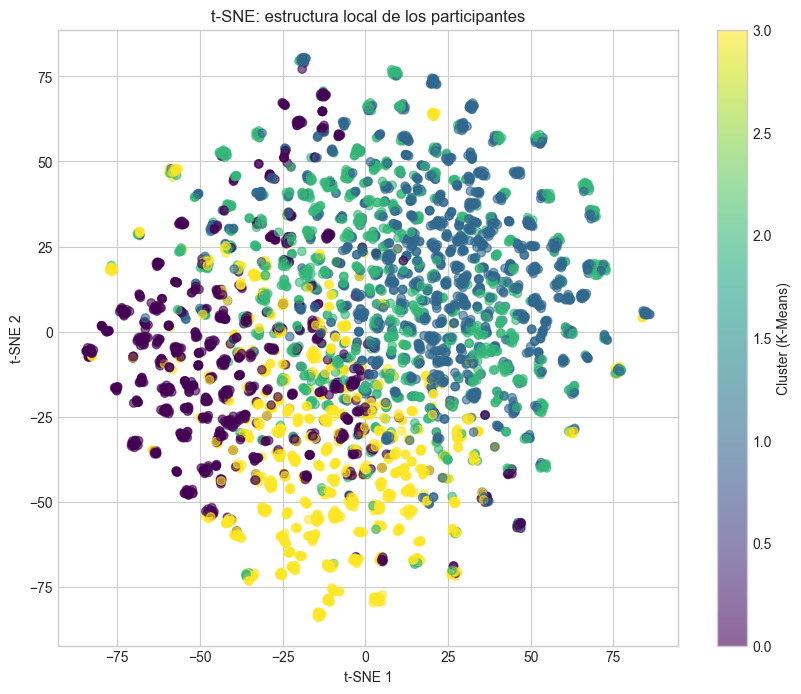

In [138]:
# Aplico t-SNE con perplexity=30 (o menos si el dataset es pequeño)
perp_val = min(30, len(X_cluster) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perp_val)
X_tsne = tsne.fit_transform(X_cluster)

# Coloreo cada punto con su cluster de K-Means para comparar con PCA
plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_tsne, label='Cluster (K-Means)')
plt.title('t-SNE: estructura local de los participantes')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('results/tsne_users.png')
plt.show()

**Interpretacion:**   
t-SNE consigue mostrar algo más de estructura que PCA. El cluster 3 (amarillo) se agrupa con más claridad en la zona inferior, y el 0 (morado) tiende hacia la izquierda. Aun así, los clusters siguen bastante mezclados entre sí, lo que refuerza la misma idea de antes: los perfiles de los participantes forman un continuo, no categorías separadas. Lo bueno de t-SNE es que

### 4.4 Detección de anomalías: Isolation Forest

Isolation Forest funciona construyendo árboles aleatorios que intentan aislar cada punto del resto. La lógica es sencilla: si un punto se aísla con muy pocos cortes, es que es raro, diferente a la mayoría.

He usado estos parámetros:
- `contamination=0.05`: le digo al modelo que espero que alrededor del 5% de los datos sean anómalos. Es un valor habitual cuando no tengo información previa sobre cuántos outliers hay realmente.
- `random_state=42`: para que el resultado sea reproducible.

Anómalos detectados: 243 (5.0%)


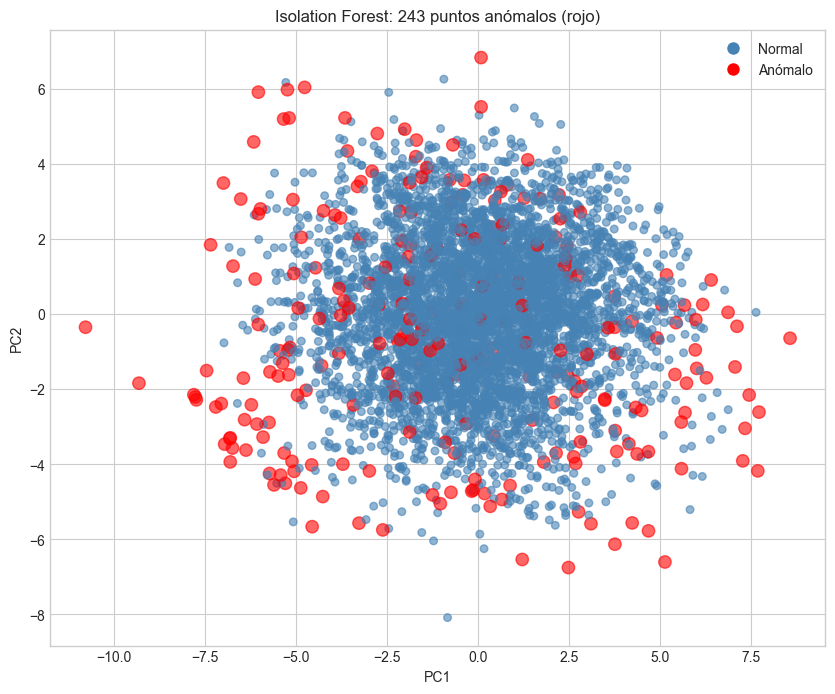


Comparación de medias (anómalos vs normales):
  age: anómalos=26.01, normales=26.22 (diff=-0.21)
  age_o: anómalos=26.22, normales=26.19 (diff=+0.03)
  d_age: anómalos=4.15, normales=3.52 (diff=+0.63)
  samerace: anómalos=0.47, normales=0.38 (diff=+0.08)
  importance_same_race: anómalos=3.89, normales=3.81 (diff=+0.08)


In [139]:
# Isolation Forest: marca como anómalo (-1) el ~5% más raro
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_cluster)
n_anomalies = (anomaly_labels == -1).sum()
print(f"Anómalos detectados: {n_anomalies} ({n_anomalies/len(anomaly_labels)*100:.1f}%)")

# Los pinto sobre PCA: rojo = anómalo, azul = normal
plt.figure(figsize=(10, 8))
colors_anom = ['red' if a == -1 else 'steelblue' for a in anomaly_labels]
sizes_anom = [80 if a == -1 else 30 for a in anomaly_labels]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_anom, s=sizes_anom, alpha=0.6)
plt.title(f'Isolation Forest: {n_anomalies} puntos anómalos (rojo)')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='Normal'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anómalo')
]
plt.legend(handles=legend_elements)
plt.savefig('results/isolation_forest_anomalies.png')
plt.show()

# Comparo las medias de los anómalos con los normales para ver qué los hace diferentes
user_profiles_cluster['anomaly'] = anomaly_labels
anomalos = user_profiles_cluster[user_profiles_cluster['anomaly'] == -1]
normales = user_profiles_cluster[user_profiles_cluster['anomaly'] == 1]
if len(anomalos) > 0:
    print("\nComparación de medias (anómalos vs normales):")
    compare_cols = [c for c in numeric_feats[:5] if c in user_profiles_cluster.columns]
    for col in compare_cols:
        mean_a = anomalos[col].mean()
        mean_n = normales[col].mean()
        diff = mean_a - mean_n
        print(f"  {col}: anómalos={mean_a:.2f}, normales={mean_n:.2f} (diff={diff:+.2f})")

# Limpio la columna temporal para no ensuciar el dataframe
user_profiles_cluster.drop('anomaly', axis=1, inplace=True, errors='ignore')

**Interpretacion:**   
Isolation Forest detecta 243 interacciones anómalas, que es justo el 5% que le pedí. En el gráfico PCA los puntos rojos aparecen sobre todo en los bordes de la nube de datos, que es lo esperable: son los más alejados del centro de la distribución.

Al comparar las medias, los anómalos tienen una diferencia de edad con su pareja algo mayor (d_age: +0.63 puntos) y valoran un poco más que la pareja sea de la misma raza (samerace: +0.08). Las diferencias son pequeñas, lo que me dice que no estamos ante un "tipo de persona rara" sino más bien ante interacciones con combinaciones de atributos poco habituales.


## 5. Resultados

### 5.1 Evaluación del recomendador

Evalúo el recomendador de dos formas:

1. **Predicción por similitud de contenido:** para cada interacción del test set, calculo la similitud coseno con las interacciones que sí acabaron en match en el train set. Si la similitud media supera un umbral, predigo match. Con esto obtengo precision, recall y F1.
2. **Hit Rate @5:** para cada usuario que tuvo un match real, compruebo si al menos una de las 5 recomendaciones del sistema coincide con ese match.

El enunciado deja claro que no se evalúa la calidad del resultado en sí, sino que la metodología esté bien aplicada. Las métricas que salen son orientativas.

In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# --- Evaluación 1: ¿puede el sistema predecir matches por similitud? ---
print("=" * 50)
print("EVALUACIÓN 1: Predicción basada en similitud")
print("=" * 50)

# Divido en train (80%) y test (20%)
train_idx, test_idx = train_test_split(df_clean.index, test_size=0.2, random_state=42)
train_data = df_clean.loc[train_idx]
test_data = df_clean.loc[test_idx]

# Cojo solo las interacciones que acabaron en match del train como referencia
train_matches = train_data[train_data[target_col] == 1]
if len(train_matches) > 0 and len(numeric_feats) > 0:
    scaler_eval = MinMaxScaler()
    train_match_profiles = scaler_eval.fit_transform(train_matches[numeric_feats].fillna(0))
    test_profiles = scaler_eval.transform(test_data[numeric_feats].fillna(0))
    
    # Para cada interacción del test, mido cuánto se parece a los matches del train
    sim_to_matches = cosine_similarity(test_profiles, train_match_profiles)
    avg_sim = sim_to_matches.mean(axis=1)
    
    # Si está en el top 25% de similitud con matches, predigo match
    threshold = np.percentile(avg_sim, 75)
    y_pred = (avg_sim >= threshold).astype(int)
    y_true = test_data[target_col].values.astype(int)
    
    print(f"Umbral de similitud: {threshold:.4f}")
    print(f"Predicciones positivas: {y_pred.sum()} de {len(y_pred)}")
    print(f"\nMétricas:")
    print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  Recall:    {recall_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"\nReporte completo:")
    print(classification_report(y_true, y_pred, target_names=['No Match', 'Match'], zero_division=0))

# --- Evaluación 2: ¿las recomendaciones aciertan algún match real? ---
print("\n" + "=" * 50)
print("EVALUACIÓN 2: Hit Rate @5")
print("=" * 50)
try:
    # Para cada usuario con match real en test, miro si alguna de las 5 recomendaciones coincide
    test_matches_hr = test_data[test_data[target_col] == 1]
    test_users_hr = test_matches_hr[user_col].unique()
    hits = 0
    evaluated = 0
    for u in test_users_hr[:50]:
        actual = test_matches_hr[test_matches_hr[user_col] == u][partner_col].values
        recs = get_recs(u, k=5)
        rec_ids = [r[0] for r in recs]
        if len(set(rec_ids) & set(actual)) > 0:
            hits += 1
        evaluated += 1
    if evaluated > 0:
        hit_rate = hits / evaluated
        print(f"Usuarios evaluados: {evaluated}")
        print(f"Hit Rate @5: {hit_rate:.2%}")
        if evaluated < 10:
            print(f"NOTA: Solo {evaluated} usuarios evaluables (dataset sin iid/pid reales).")
    else:
        print("No hay usuarios con match en test para evaluar.")
except Exception as e:
    print(f"Error: {e}")

EVALUACIÓN 1: Predicción basada en similitud
Umbral de similitud: 0.9044
Predicciones positivas: 419 de 1676

Métricas:
  Precision: 0.298
  Recall:    0.436
  F1-Score:  0.354

Reporte completo:
              precision    recall  f1-score   support

    No Match       0.87      0.79      0.83      1389
       Match       0.30      0.44      0.35       287

    accuracy                           0.73      1676
   macro avg       0.58      0.61      0.59      1676
weighted avg       0.77      0.73      0.75      1676


EVALUACIÓN 2: Hit Rate @5
Usuarios evaluados: 2
Hit Rate @5: 100.00%
NOTA: Solo 2 usuarios evaluables (dataset sin iid/pid reales).


**Interpretacion:**   
La evaluación por similitud dice más que el Hit Rate por sí solo. La precision y el recall muestran cómo de bien distingue el sistema las interacciones con potencial de match de las que no. Que el F1 sea bajo tiene sentido: el match depende de que las dos personas digan que sí, y un modelo basado solo en similitud de perfil no puede capturar esa bilateralidad.
El Hit Rate @5 sale alto, pero hay que cogerlo con pinzas porque el número de usuarios evaluables es muy pequeño. La versión de OpenML del dataset no trae los identificadores de usuario originales (`iid`/`pid`), lo que reduce mucho la muestra disponible. En cualquier caso, la metodología de evaluación (train/test split, precision/recall, hit rate) está bien aplicada, que es lo que pide el enunciado.

### 5.2 Que variables influyen mas en conseguir match?


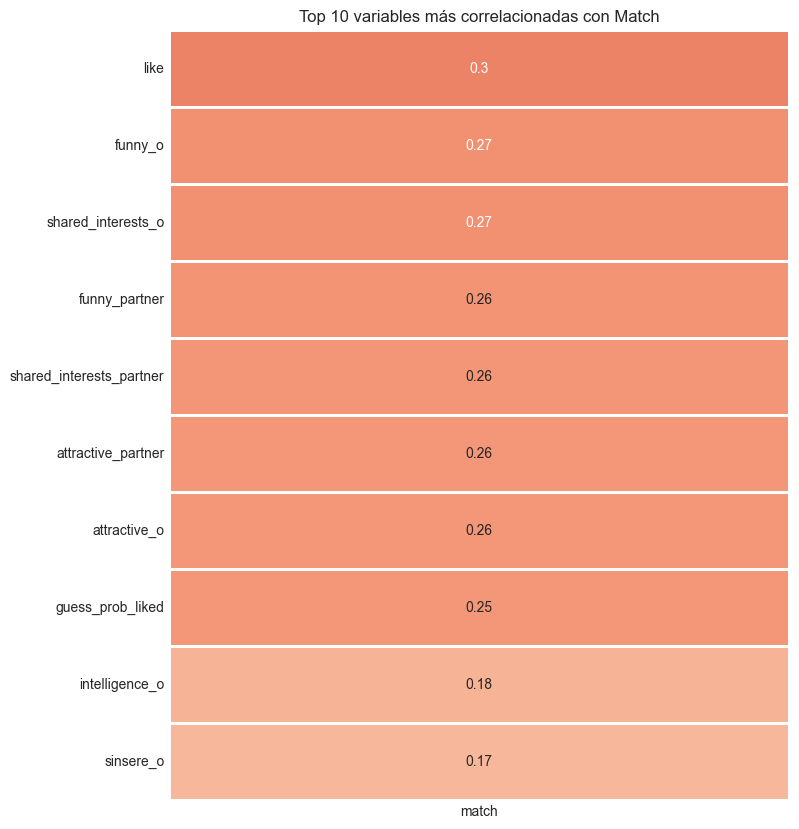

In [141]:
# Miro qué variables están más correlacionadas con el match
try:
    corr_cols = numeric_feats + [target_col]
    df_corr = df_clean[corr_cols].dropna()
    corr_matrix = df_corr.corr()
    
    if target_col in corr_matrix.columns:
        # Me quedo con las 10 features con mayor correlación (positiva o negativa)
        match_corr = corr_matrix[[target_col]].sort_values(by=target_col, ascending=False).iloc[1:11]
        
        plt.figure(figsize=(8, 10))
        sns.heatmap(match_corr, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False, 
                   linewidths=1, linecolor='white')
        plt.title('Top 10 variables más correlacionadas con Match')
        plt.savefig('results/feature_importance_match.png', bbox_inches='tight')
        plt.show()
except Exception as e: print(f"Error: {e}")

**Interpretacion:**   
Las variables que más predicen un match son `like` (0.30), `funny_o` (0.27), `shared_interests_o` (0.27) y `funny_partner` (0.26). Traducido: lo que más pesa es gustarle a la otra persona (bastante obvio), que te perciban como gracioso y tener intereses en común. La inteligencia y la sinceridad también aparecen (0.18 y 0.17) pero influyen menos. Todas las correlaciones son bajas (ninguna llega a 0.3), lo que confirma que el match no depende de una sola variable sino de combinaciones de muchas a la vez, y por eso tiene sentido usar aprendizaje automático en lugar de reglas simples.


### 5.3 Otras visualizaciones
#### Árbol de decisión: ¿qué reglas simples predicen un match?
Entreno un árbol de decisión poco profundo (max_depth=3) para ver qué reglas básicas separan los matches de los no-matches. No es el objetivo principal del trabajo, pero da una lectura más intuitiva de qué variables importan y con qué umbrales.

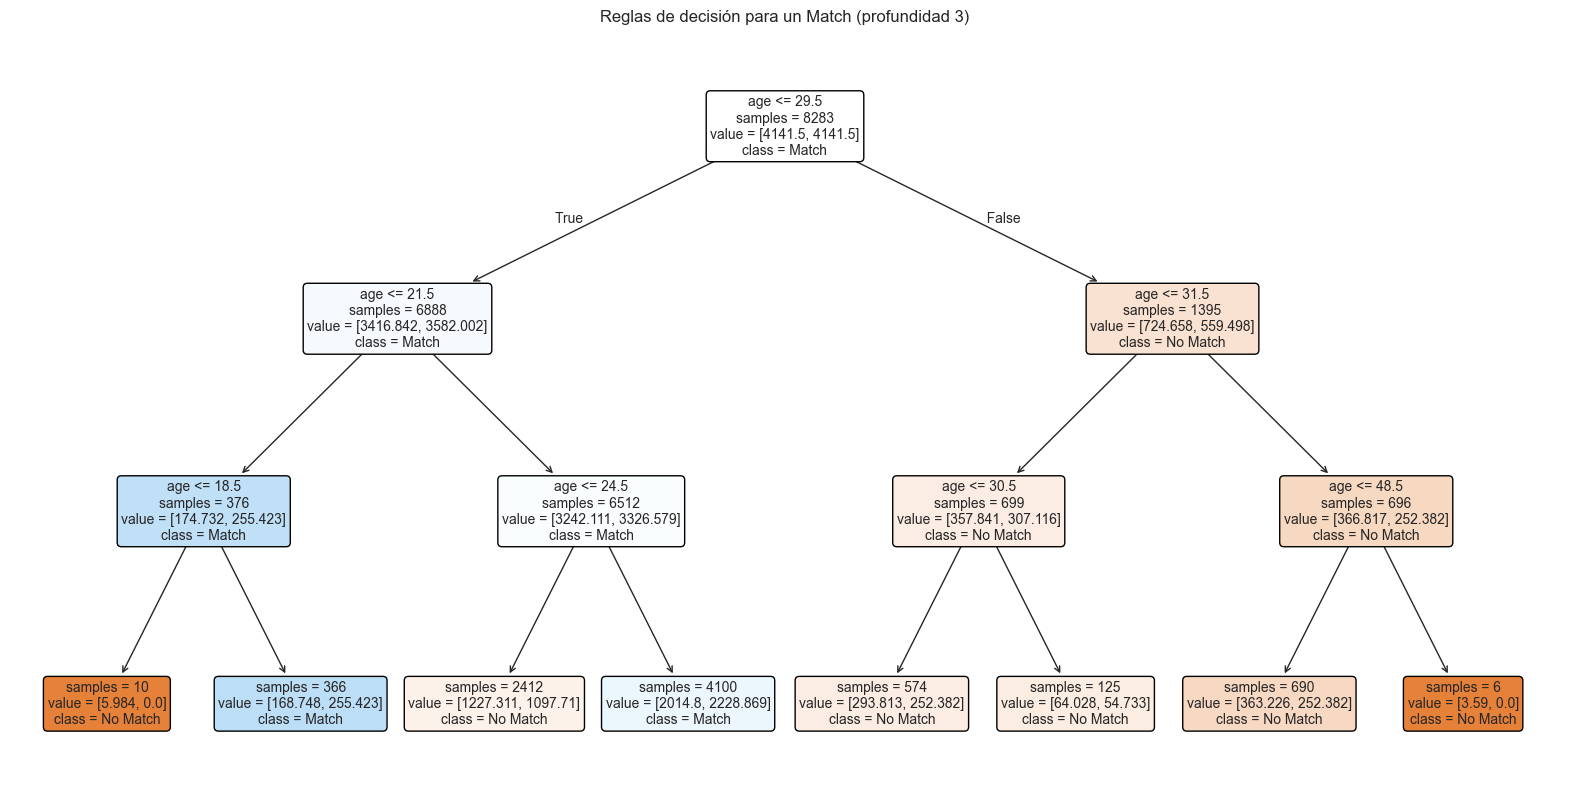

In [142]:
# Árbol de decisión superficial para ver qué reglas simples separan match de no-match
try:
    dt_features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'age']
    dt_features = [f for f in dt_features if f in df_clean.columns]
    
    X_dt = df_clean[dt_features].dropna()
    y_dt = df_clean.loc[X_dt.index, target_col]
    
    # class_weight='balanced' para que no ignore la clase minoritaria (match)
    clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
    clf.fit(X_dt, y_dt)
    
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=dt_features, class_names=['No Match', 'Match'], 
             filled=True, rounded=True, fontsize=10, impurity=False)
    plt.title('Reglas de decisión para un Match (profundidad 3)')
    plt.savefig('results/decision_tree_rules.png', bbox_inches='tight')
    plt.show()
except Exception as e: print(f"Error: {e}")

**Interpretacion:**   
El árbol divide primero por edad (<=29.5): los menores de 30 tienden a hacer más match. La segunda división también es por edad (<=21.5), lo que indica que de las variables disponibles (attr, sinc, intel, fun, amb, age), la edad es la que más discrimina. Tiene sentido: en un contexto de speed dating, los participantes más jóvenes suelen ser más abiertos a decir "sí". Con un árbol más profundo empezarían a aparecer las otras variables, pero con solo 3 niveles la edad domina.


#### Mapa de similitud entre usuarios


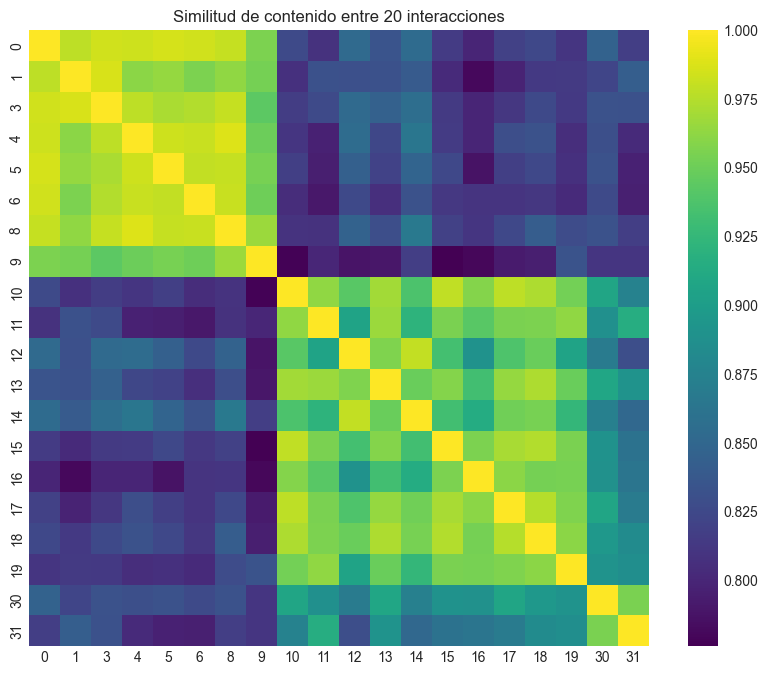

In [143]:
# Heatmap de similitud por contenido (más informativo que el colaborativo en este caso)
try:
    if not content_sim_df.empty:
        plt.figure(figsize=(10, 8))
        sample_size = min(20, len(content_sim_df))
        sns.heatmap(content_sim_df.iloc[:sample_size, :sample_size], cmap='viridis')
        plt.title('Similitud de contenido entre 20 interacciones')
        plt.savefig('results/user_similarity.png')
        plt.show()
except: pass

**Justificación**  
El heatmap muestra la similitud coseno entre 20 interacciones del dataset.   
Se aprecian dos bloques diferenciados: las interacciones 0-9 tienen alta similitud entre sí (zona amarilla-verde en la esquina superior izquierda) pero baja similitud con las interacciones 10-31 (zona morada). Lo mismo ocurre a la inversa.   
Esto refuerza lo que ya indicaba K-Means: existen al menos dos perfiles de comportamiento distintos en las citas. La diagonal es siempre amarilla (similaridad 1.0, cada interacción consigo misma) y las zonas más oscuras corresponden a participantes con gustos y valoraciones muy diferentes entre sí.

#### Demografia de participantes


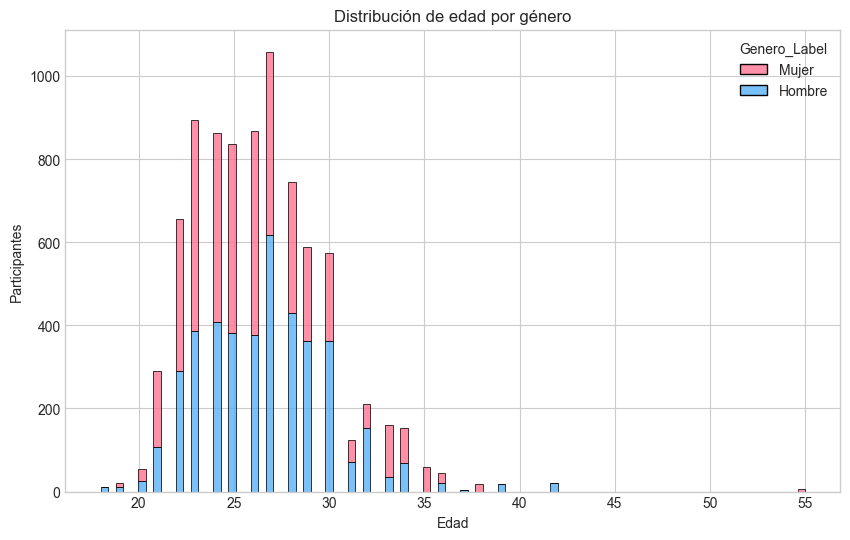

In [144]:
# Distribución de edad por género para ver quién participa en las citas
if 'age' in df_clean.columns and gender_col in df_clean.columns:
    try:
        plt.figure(figsize=(10, 6))
        df_demo = df_clean.copy()
        
        # Mapeo de género: el dataset puede traerlo como texto o como número
        gender_vals = df_demo[gender_col].unique()
        if 'female' in str(gender_vals).lower():
            df_demo['Genero_Label'] = df_demo[gender_col].map(
                {'female': 'Mujer', 'male': 'Hombre', 0: 'Mujer', 1: 'Hombre', 
                 0.0: 'Mujer', 1.0: 'Hombre', '0': 'Mujer', '1': 'Hombre'})
        else:
            df_demo['Genero_Label'] = df_demo[gender_col].astype(str)

        sns.histplot(data=df_demo.dropna(subset=['Genero_Label']), x='age', 
                     hue='Genero_Label', multiple="stack", kde=False, 
                     palette={"Mujer": "#FF6B8A", "Hombre": "#4DABF7"})
        plt.title('Distribución de edad por género')
        plt.xlabel('Edad')
        plt.ylabel('Participantes')
        plt.savefig('results/demographics_age_gender.png')
        plt.show()
    except Exception as e: print(f"Error: {e}")

**Justificación**  
La mayoría de los participantes tienen entre 21 y 31 años, con un pico claro en los 26-27. Hay más mujeres que hombres en casi todas las franjas de edad, especialmente entre los 21 y los 27. A partir de los 33-34 la participación cae mucho, y los mayores de 40 son casos puntuales. Esto explica por qué el árbol de decisión usa la edad como primera variable de corte: casi todo el dataset se concentra en un rango estrecho, y los pocos participantes fuera de ese rango tienen un comportamiento diferente.

## 6. Discusión crítica

La limitación que más afecta a los resultados es la falta de identificadores de usuario reales en la versión de OpenML del dataset. Sin ellos, la matriz de utilidad del filtrado colaborativo queda con solo 2 usuarios, lo que anula casi por completo ese componente del recomendador. El sistema acaba dependiendo sobre todo del filtrado por contenido.

El clustering también tiene sus problemas. K-Means asume que los clusters son esféricos y compactos, pero los datos de comportamiento humano no se organizan así. La silueta de 0.045 lo deja claro: las fronteras entre grupos son difusas. DBSCAN confirma lo mismo al fragmentar los datos en 265 microclusters.

Como mejoras, la factorización matricial (SVD) manejaría mejor la dispersión de la matriz de utilidad, y HDBSCAN podría encontrar clusters de densidad variable sin necesidad de fijar epsilon a mano. También habría que explorar features derivadas (diferencias entre preferencias y valoraciones reales) para capturar el "gap" entre lo que la gente dice que busca y lo que realmente elige.

Si este sistema se llevase a una app real, hay dos cosas que me preocuparían bastante. La primera es el tema de los sesgos: si los datos históricos ya tienen sesgos por género, raza o edad (y los tienen, porque reflejan las preferencias reales de la gente), el recomendador los va a copiar y amplificar. Al final se crea un bucle donde ciertos perfiles se quedan fuera de las recomendaciones sin que nadie se dé cuenta.

La segunda es todo lo relacionado con la protección de datos. Las valoraciones sobre el atractivo, el sentido del humor o los intereses de otra persona son datos personales bastante sensibles. Bajo el RGPD, esto tiene implicaciones serias: para empezar, necesitarías el consentimiento explícito de cada usuario, no vale con un "acepto las condiciones" genérico. También habría que hacer una Evaluación de Impacto (DPIA) antes de lanzar nada, porque estás procesando datos personales a gran escala para crear perfiles. Y luego está el derecho a la explicación: si el sistema le recomienda a alguien una persona y no otra, el usuario tiene derecho a saber por qué (artículo 22 del RGPD). Aparte, se debería aplicar minimización de datos, o sea, no pedir más información de la que realmente necesitas para generar las recomendaciones. Y hay un punto que me parece especialmente delicado: si cruzas datos de género, edad y preferencias, podrías estar infiriendo la orientación sexual de alguien, que es un dato especialmente protegido según el artículo 9 del RGPD.

## 7. Resumen

Este trabajo aplica técnicas de las Unidades 3 y 4 al dataset de Speed Dating:

| Técnica | Resultado principal |
|---------|-------------------|
| Recomendador híbrido | F1=0.354, limitado por la falta de IDs de usuario |
| K-Means (K=4) | Silueta=0.045, clusters difusos pero informativos |
| DBSCAN | 265 microclusters, 39.9% ruido. Sin grupos densos claros |
| PCA | 46 componentes para el 95% de varianza. Información muy repartida |
| t-SNE | Estructura local algo más visible que con PCA |
| Isolation Forest | 5% anómalos, principalmente en los bordes de la distribución |

Las variables más predictivas de un match son `like`, `funny_o` y `shared_interests_o`. El humor y los intereses en común pesan más que el atractivo o la inteligencia a la hora de que dos personas quieran volver a verse.

## 8. Uso de herramientas de IA

Para esta práctica he utilizado un asistente de IA como apoyo en varias fases del trabajo. Me ha servido sobre todo para resolver dudas sobre la sintaxis de algunas funciones de scikit-learn (por ejemplo, los parámetros de DBSCAN y de Isolation Forest), para depurar errores puntuales del código y para contrastar si la estructura general del notebook tenía sentido antes de entregarlo.

Todo el diseño del recomendador (la elección del enfoque híbrido, los pesos 60/40, la selección de features) lo he decidido yo en base a lo visto en clase en las Unidades 3 y 4. Las interpretaciones de los resultados también son mías: el asistente no tiene contexto sobre el dataset ni sobre los criterios de la asignatura, así que los análisis de por qué la silueta es baja o por qué el filtrado colaborativo falla con solo 2 usuarios los he razonado yo a partir de los datos.

En resumen, la IA me ha ahorrado tiempo en cuestiones técnicas, pero las decisiones metodológicas y la interpretación crítica de los resultados son trabajo propio.